In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
pd

<module 'pandas' from 'C:\\Users\\juxtapose\\anaconda3\\Lib\\site-packages\\pandas\\__init__.py'>

In [3]:
df_train = pd.read_csv('flight_delays_train.csv')

In [4]:
df_test = pd.read_csv('flight_delays_test.csv')

In [5]:
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


Оба датафрейма не содержат пустые значения

In [9]:
df_train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [10]:
df_test.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1338.936600,723.13011
std,480.554102,563.22322
min,1.000000,31.00000
25%,928.000000,321.00000
50%,1329.000000,574.00000
75%,1733.000000,948.00000
max,2400.000000,4962.00000


Баланс классов

In [72]:
df_train['dep_delayed_15min'].value_counts(normalize=True)

dep_delayed_15min
0    0.80956
1    0.19044
Name: proportion, dtype: float64

In [11]:
all_data = pd.concat([df_train, df_test], ignore_index=True)

In [12]:
def to_int(cat):
    if cat == 'Y':
        return 1
    if cat == 'N':
        return 0

In [13]:
df_train['dep_delayed_15min'] = df_train['dep_delayed_15min'].apply(to_int)
all_data['dep_delayed_15min'] = all_data['dep_delayed_15min'].apply(to_int)

In [14]:
df_train["Month"] = df_train["Month"].str.replace("c-", "").astype(int)
df_train["DayofMonth"] = df_train["DayofMonth"].str.replace("c-", "").astype(int)
df_train["DayOfWeek"] = df_train["DayOfWeek"].str.replace("c-", "").astype(int)
all_data["Month"] = all_data["Month"].str.replace("c-", "").astype(int)
all_data["DayofMonth"] = all_data["DayofMonth"].str.replace("c-", "").astype(int)
all_data["DayOfWeek"] = all_data["DayOfWeek"].str.replace("c-", "").astype(int)

## Аналитика по месяцам

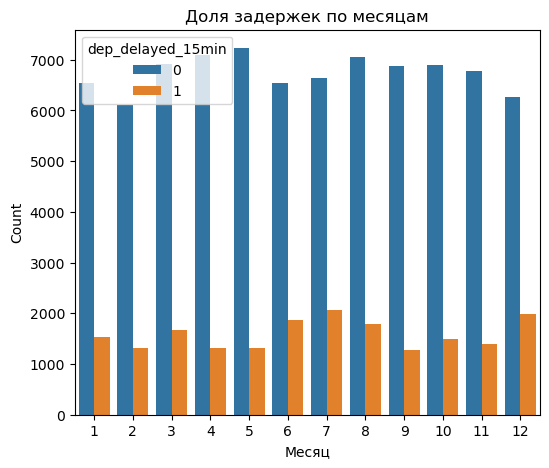

In [15]:
plt.figure(figsize=(6, 5))  # Создаём отдельную фигуру
sns.countplot(x='Month', hue='dep_delayed_15min', data=df_train)
plt.title('Доля задержек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Count')
plt.show()

На гистограмме можно видеть нормальное распределение, однако летом и в декабре видно
повышенное количество задержек (Это может быть связано с погодными условиями или количеством отпусков)

## Аналитика по дням месяца

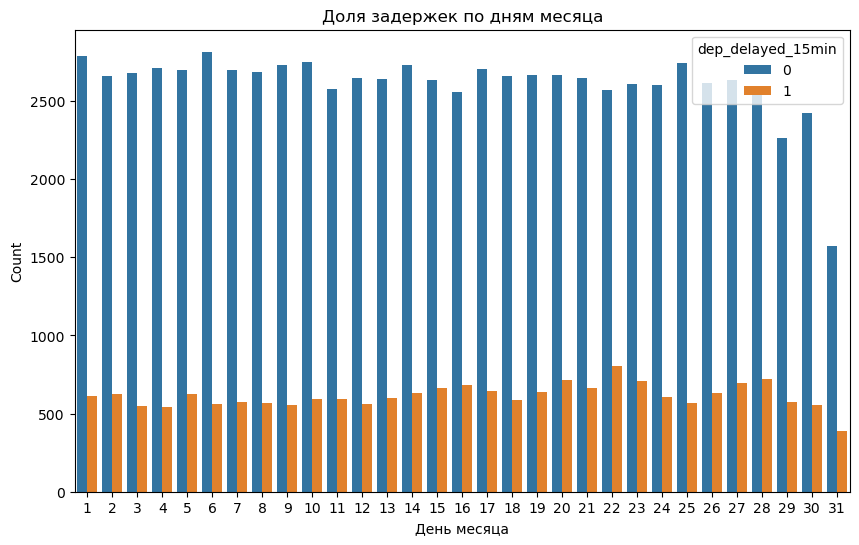

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DayofMonth', data=df_train, hue='dep_delayed_15min')
plt.title('Доля задержек по дням месяца')
plt.xlabel('День месяца')
plt.ylabel('Count')
plt.show()

Данная гистограмма тоже показывает нормальное распределение, при этом здесь трудно выявить какие-то
закономерности, однако можно увидеть, что под конец месяца относительное количество 
задержек увеличивается.

## Аналитика по дню недели

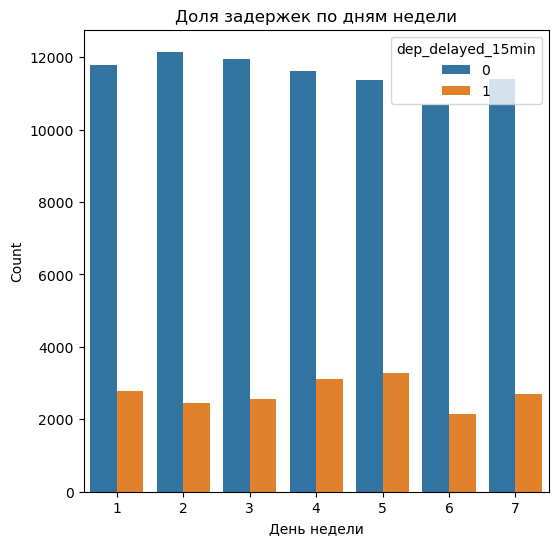

In [17]:
plt.figure(figsize=(6, 6))
sns.countplot(x='DayOfWeek', data=df_train, hue='dep_delayed_15min')
plt.title('Доля задержек по дням недели')
plt.xlabel('День недели')
plt.ylabel('Count')
plt.show()

In [18]:
delay_counts = df_train.groupby('DayOfWeek')['dep_delayed_15min'].sum().reset_index()

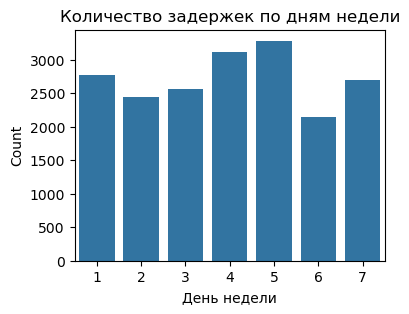

In [19]:
plt.figure(figsize=(4, 3))
sns.barplot(x='DayOfWeek', y='dep_delayed_15min', data=delay_counts)
plt.title('Количество задержек по дням недели')
plt.xlabel('День недели')
plt.ylabel('Count')
plt.show()

Можно увидеть, что в четверг и пятницу происходило больше всего задержек, при этом в субботу меньше всего.

## Аналитика по времени отправления

Text(0.5, 0, 'Departure Time')

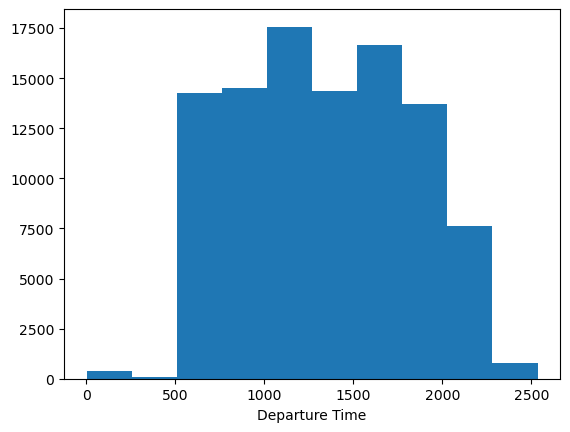

In [20]:
plt.hist(df_train.DepTime)
plt.xlabel('Departure Time')

На графике видно, что большинство полетов происходит после 5 утра.  В том числе 
к вечеру их число уменьшается. Так же можно заметить, что время лежит в промежутке до 2534, что является нередкой практикой записи полетов в авиакомпаниях. 
Для этой фичи необходимо будет провести инженеринг.

## Аналитика по "Unique Carrier"

In [21]:
print(len(df_train['UniqueCarrier'].unique()))

22


Text(0, 0.5, 'Count')

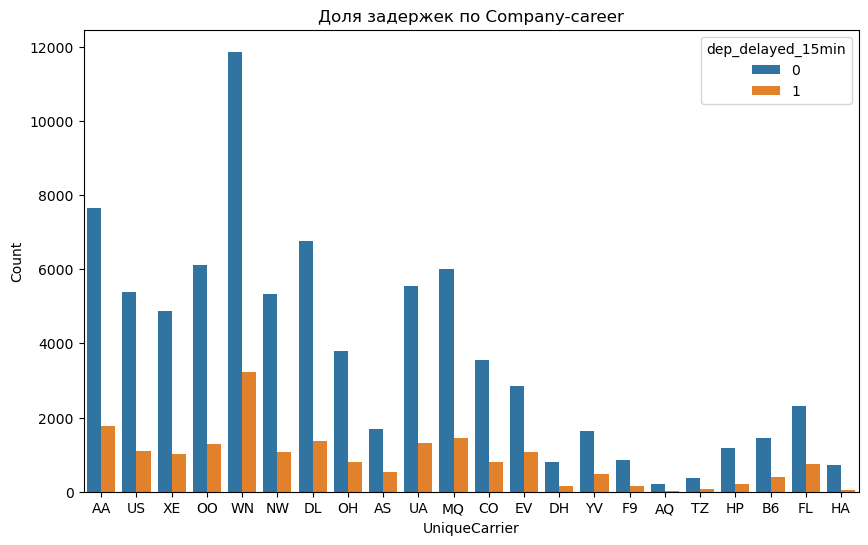

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='UniqueCarrier', hue='dep_delayed_15min', data=df_train)
plt.title('Доля задержек по Company-career')
plt.xlabel('UniqueCarrier')
plt.ylabel('Count')

Возможно фича UnqieCarrier может сыграть важную роль в корректной классификации.

## Origin и Destination (Начало пути и пункт назначения

In [23]:
print(len(df_train['Origin'].unique()))
print(len(df_train['Dest'].unique()))

289
289


Слишком много фич для построения гистограммы. Можно будет попробовать объединить фичи в Origin_Destination

## Distance

Text(0.5, 0, 'Расстояние')

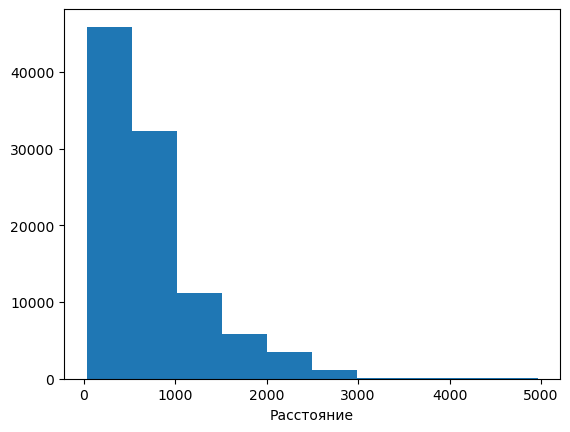

In [24]:
plt.hist(df_train.Distance)
plt.xlabel('Расстояние')

Большинство полетов совершаются на короткие расстояния.
Можно будет разбить distance на фичи по 500 миль

## Feature engineering

### 1. Временные метки

Разбиение месяцев на сезоны

In [25]:
all_data['winter'] = (all_data['Month'].isin([12, 1, 2]))
all_data['spring'] = (all_data['Month'].isin([3, 4, 5]))
all_data['summer'] = (all_data['Month'].isin([6, 7, 8]))
all_data['autumn'] = (all_data['Month'].isin([9, 10, 11]))

Категоризация времени на разные составляющие дня (От ночи до вечера)

In [26]:
all_data.loc[all_data.DepTime <= 600 , 'DepTime_bin'] = 'Night'
all_data.loc[(all_data.DepTime > 600) & (all_data.DepTime <= 1200), 'DepTime_bin'] = 'Morning'
all_data.loc[(all_data.DepTime > 1200) & (all_data.DepTime <= 1800), 'DepTime_bin'] = 'Afternoon'
all_data.loc[(all_data.DepTime > 1800) & (all_data.DepTime <= 2600), 'DepTime_bin'] = 'Evening'

In [27]:
all_data['DepTime_bin'] = ''
all_data.loc[all_data.DepTime <= 600 , 'DepTime_bin'] = 'night'
all_data.loc[(all_data.DepTime > 600) & (all_data.DepTime <= 900), 'DepTime_bin'] = 'morning'
all_data.loc[(all_data.DepTime > 900) & (all_data.DepTime <= 1200), 'DepTime_bin'] = 'late_morning'
all_data.loc[(all_data.DepTime > 1200) & (all_data.DepTime <= 1500), 'DepTime_bin'] = 'day'
all_data.loc[(all_data.DepTime > 1500) & (all_data.DepTime <= 1800), 'DepTime_bin'] = 'early_evening'
all_data.loc[(all_data.DepTime > 1800) & (all_data.DepTime <= 2100), 'DepTime_bin'] = 'evening'
all_data.loc[(all_data.DepTime > 2100) & (all_data.DepTime <= 2400), 'DepTime_bin'] = 'late_evening'
all_data.loc[all_data.DepTime > 2400, 'DepTime_bin'] = 'night'

Разбиение времени на две составляющие: часы и минуты.

Нормализация 25 и 24 часа (Которые являются 0м и 1м часом).

Возведем часы в степень для добавления нелинейности.

Явно зададим фичи, которые указвают на конец месяца и выходные

In [28]:
all_data['hour'] = all_data['DepTime'] // 100
all_data.loc[all_data['hour'] == 24, 'hour'] = 0
all_data.loc[all_data['hour'] == 25, 'hour'] = 1
all_data['minute'] = all_data['DepTime'] % 100

In [29]:
all_data['hour_sq'] = all_data['hour'] ** 2
all_data['hour_sq2'] = all_data['hour'] ** 4

In [30]:
all_data['is_weekend'] = (all_data['DayOfWeek'] == 6) | (all_data['DayOfWeek'] == 7)

In [31]:
all_data['is_endOfMonth'] = (all_data['DayofMonth'] >= 29) & (all_data['DayofMonth'] <= 31)

## 2. Маршруты и расстояние

Добавляем маршрут 

In [32]:
all_data['Route'] = all_data['Origin'] + all_data['Dest']

In [33]:
all_data['Dist_bin'] = ''
all_data.loc[all_data.Distance <= 500 , 'Dist_bin'] = 'very_short'
all_data.loc[(all_data.Distance > 500) & (all_data.Distance <= 1000), 'Dist_bin'] = 'short'
all_data.loc[(all_data.Distance > 1000) & (all_data.Distance <= 1500), 'Dist_bin'] = 'mid'
all_data.loc[(all_data.Distance > 1500) & (all_data.Distance <= 2000), 'Dist_bin'] = 'mid_long'
all_data.loc[(all_data.Distance > 2000) & (all_data.Distance <= 2500), 'Dist_bin'] = 'long'
all_data.loc[all_data.Distance > 2500, 'Dist_bin'] = 'very_long'


In [34]:
all_data['UniqueCarrier_Origin'] = all_data['UniqueCarrier'] + "_" + all_data['Origin']
all_data['UniqueCarrier_Dest'] = all_data['UniqueCarrier'] + "_" + all_data['Dest']

In [35]:
all_data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,winter,...,hour,minute,hour_sq,hour_sq2,is_weekend,is_endOfMonth,Route,Dist_bin,UniqueCarrier_Origin,UniqueCarrier_Dest
0,8,21,7,1934,AA,ATL,DFW,732,0.0,False,...,19,34,361,130321,True,False,ATLDFW,short,AA_ATL,AA_DFW
1,4,20,3,1548,US,PIT,MCO,834,0.0,False,...,15,48,225,50625,False,False,PITMCO,short,US_PIT,US_MCO
2,9,2,5,1422,XE,RDU,CLE,416,0.0,False,...,14,22,196,38416,False,False,RDUCLE,very_short,XE_RDU,XE_CLE
3,11,25,6,1015,OO,DEN,MEM,872,0.0,False,...,10,15,100,10000,True,False,DENMEM,short,OO_DEN,OO_MEM
4,10,7,6,1828,WN,MDW,OMA,423,1.0,False,...,18,28,324,104976,True,False,MDWOMA,very_short,WN_MDW,WN_OMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN,False,...,8,52,64,4096,False,False,CRPHOU,very_short,WN_CRP,WN_HOU
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN,False,...,14,46,196,38416,True,False,ORDLAS,mid_long,UA_ORD,UA_LAS
199997,1,30,2,1509,OO,ORD,SGF,438,NaN,True,...,15,9,225,50625,False,True,ORDSGF,very_short,OO_ORD,OO_SGF
199998,1,5,5,804,DL,LGA,ATL,761,NaN,True,...,8,4,64,4096,False,False,LGAATL,short,DL_LGA,DL_ATL


In [36]:
fit_train = all_data.iloc[:100_000]
fit_test = all_data.iloc[100_000:]

In [37]:
fit_test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,winter,...,hour,minute,hour_sq,hour_sq2,is_weekend,is_endOfMonth,Route,Dist_bin,UniqueCarrier_Origin,UniqueCarrier_Dest
100000,7,25,3,615,YV,MRY,PHX,598,NaN,False,...,6,15,36,1296,False,False,MRYPHX,short,YV_MRY,YV_PHX
100001,4,17,2,739,WN,LAS,HOU,1235,NaN,False,...,7,39,49,2401,False,False,LASHOU,mid,WN_LAS,WN_HOU
100002,12,2,7,651,MQ,GSP,ORD,577,NaN,True,...,6,51,36,1296,True,False,GSPORD,short,MQ_GSP,MQ_ORD
100003,3,25,7,1614,WN,BWI,MHT,377,NaN,False,...,16,14,256,65536,True,False,BWIMHT,very_short,WN_BWI,WN_MHT
100004,6,6,3,1505,UA,ORD,STL,258,NaN,False,...,15,5,225,50625,False,False,ORDSTL,very_short,UA_ORD,UA_STL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN,False,...,8,52,64,4096,False,False,CRPHOU,very_short,WN_CRP,WN_HOU
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN,False,...,14,46,196,38416,True,False,ORDLAS,mid_long,UA_ORD,UA_LAS
199997,1,30,2,1509,OO,ORD,SGF,438,NaN,True,...,15,9,225,50625,False,True,ORDSGF,very_short,OO_ORD,OO_SGF
199998,1,5,5,804,DL,LGA,ATL,761,NaN,True,...,8,4,64,4096,False,False,LGAATL,short,DL_LGA,DL_ATL


In [38]:
features = list(fit_train.columns)
features.remove('dep_delayed_15min')

In [39]:
X = fit_train[features]
y = fit_train.dep_delayed_15min

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=77)

In [41]:
count = -1
for i in features:
    count += 1
    print(i, " ", count)

Month   0
DayofMonth   1
DayOfWeek   2
DepTime   3
UniqueCarrier   4
Origin   5
Dest   6
Distance   7
winter   8
spring   9
summer   10
autumn   11
DepTime_bin   12
hour   13
minute   14
hour_sq   15
hour_sq2   16
is_weekend   17
is_endOfMonth   18
Route   19
Dist_bin   20
UniqueCarrier_Origin   21
UniqueCarrier_Dest   22


In [43]:
cat_features = [4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22]

In [49]:
model_GridSCV = CatBoostClassifier(silent=True, random_seed=77)

In [57]:
param_grid = {
    'iterations': [3000, 2500],
    'learning_rate': [0.05, 0.03],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [0.8, 1.6, 2.4]
}

In [58]:
grid_search = GridSearchCV(
    estimator=model_GridSCV,
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    cv=2,
    n_jobs=-1
)

In [59]:
grid_search.fit(X_train, y_train, cat_features=[4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22])

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000191A3E7C2F0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [3000, 2500],
                         'l2_leaf_reg': [0.8, 1.6, 2.4],
                         'learning_rate': [0.05, 0.03]},
             scoring='roc_auc', verbose=2)

In [60]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат:", grid_search.best_score_)

Лучшие параметры: {'depth': 6, 'iterations': 3000, 'l2_leaf_reg': 2.4, 'learning_rate': 0.05}
Лучший результат: 0.7764843345608664


In [68]:
model_ctb = CatBoostClassifier(iterations=3000, loss_function='Logloss',
                               l2_leaf_reg=2.4, od_type='Iter',
                               learning_rate=0.05,
                               random_seed=17, silent=True)
start_time = time.time()
model_ctb.fit(X_train, 
              y_train.astype(int), 
              cat_features=cat_features)
end_time = time.time()
execution_time = (end_time - start_time) / 60
print(f"Время выполнения: {execution_time:.4f} минут")

Время выполнения: 5.0105 минут


In [69]:
predictions = model_ctb.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val.astype(int), predictions)
print('Roc Auc score: ', roc)

Roc Auc score:  0.8244646885417166


In [70]:
predictions = model_ctb.predict_proba(fit_test[features])[:, 1]
submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
submission.tail()

,id,dep_delayed_15min
99995,99995,0.019200
99996,99996,0.060216
99997,99997,0.286302
99998,99998,0.185614
99999,99999,0.143527


In [71]:
submission.to_csv('delays_submoission.csv', index=False)